# LSTM on Amazon fine food review

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer as sno
setofstopwords=set(stopwords.words('english'))
nltk.download('stopwords')


[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

### Loading from database

In [2]:
conn= sqlite3.connect('database.sqlite')
data= pd.read_sql_query('''
SELECT * FROM Reviews WHERE Score!=3
''',conn)
data.shape

(525814, 10)

### Removing not helpful reviews

In [3]:
data['Score']=data['Score'].map(lambda x:'Positive' if x>3 else 'Negative')
sorteddata= data.sort_values('ProductId',axis=0)
finaldata= sorteddata.drop_duplicates(subset={'UserId','ProfileName',\
        'Time','Text'}, keep='first',inplace=False)

finaldata= finaldata[finaldata['HelpfulnessNumerator'] <= finaldata['HelpfulnessDenominator']]
data= finaldata.sort_values('Time',axis=0)
data.shape

(364171, 10)

### Cleaning HTML, punctuations, apply stemming, lowercasing etc without removing stopwords

In [4]:
def cleanhtml(sentance): #substitute expression contained in <> with ' '
    cleaned= re.sub(re.compile('<.*?>'),' ',sentance)
    return cleaned
#function for removing punctuations chars
def cleanpunc(sentance):
    cleaned= re.sub(r'[?|!|\'|"|#]',r'',sentance)
    cleaned= re.sub(r'[.|,|)|(|\|/]',r'',sentance)
    return cleaned
snowstem= sno('english')

i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
for sent in data['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        # we have used cleanpunc(w).split(), one more split function here 
        # because consider w="abc.def", cleanpunc(w) will return "abc def"
        # if we dont use .split() function then we will be considring "abc def" 
        # as a single word, but if you use .split() function we will get "abc", "def"
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                s=(snowstem.stem(cleaned_words.lower())).encode('utf8')
                filtered_sentence.append(s)
                if(data['Score'].values)[i] =='Positive':
                    all_positive_words.append(s)
                if(data['Score'].values)[i] =='Negative':
                    all_negative_words.append(s)
            else:
                continue
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    final_string.append(str1)

# storing data till now
data['CleanedText']=final_string 
#adding a column of CleanedText which displays the data after pre-processing of the review 
data['CleanedText']=data['CleanedText'].str.decode("utf-8")
    # store final table into an SQlLite table for future.
conn = sqlite3.connect('cleanedTextData.sqlite')
c=conn.cursor()
conn.text_factory = str
data.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
        index=True, index_label=None, chunksize=None, dtype=None)
conn.close()

In [5]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,Positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,this witti littl book make son laugh loud reci...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,Positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,can rememb see the show when air televis year ...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,Positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth about fro...
346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,Positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,Positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel and funni movi keaton hilari ...


In [6]:
data['Text'][2]

'This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavorful.  I highly recommend this yummy treat.  If you are familiar with the story of C.S. Lewis\' "The Lion, The Witch, and The Wardrobe" - this is the treat that seduces Edmund into selling out his Brother and Sisters to the Witch.'

In [7]:
data['CleanedText'][2]

'this confect that has been around few centuri light pillowi citrus gelatin with nut this case filbert and cut into tini squar and then liber coat with powder sugar and tini mouth heaven not too chewi and veri flavor high recommend this yummi treat you are familiar with the stori lion the witch and the this the treat that seduc edmund into sell out his brother and sister the witch'

### Taking 100k datapoints

In [8]:
Data= data[:100000]
Data= Data[['CleanedText','Score']]
Data['Score']= Data['Score'].map(lambda x:1 if x=='Positive' else 0)

Data_x= Data['CleanedText']
Data_y= Data['Score']

In [9]:
Data_x.index= [i for i in range(0,10**5)]
Data_x

0        this witti littl book make son laugh loud reci...
1        can rememb see the show when air televis year ...
2        beetlejuic well written movi everyth about fro...
3        twist rumplestiskin captur film star michael k...
4        beetlejuic excel and funni movi keaton hilari ...
5        this one movi that should your movi collect fi...
6        myself alway enjoy this movi veri funni and en...
7        bought few these after apart was infest with f...
8        what happen when you say his name three michae...
9        get look for beatlejuic french version video r...
10       get crazi realli imposs today not find the fre...
11       this was realli good idea and the final produc...
12       just receiv shipment and could hard wait tri t...
13       have just recent purchas the woodstream corp g...
14       this are much easier use than the wilson past ...
15       these are easi use they not make mess and offe...
16       this such great film even know how sum first a.

### Making Vocabulary set and Frequency dictionary of words

In [10]:
# collecting all words in single list
list_= []
for i in Data_x:
    list_ += i
list_= ''.join(list_)
allWords=list_.split()

In [11]:
vocabulary= set(allWords)

In [12]:
vocabulary_list= list(vocabulary)

In [13]:
#frequency dictionary
freq_dict= {}
for word in vocabulary_list:
    freq_dict[word]= allWords.count(word)

In [14]:
freq_dict

{'mouthhonest': 1,
 'gardenhad': 1,
 'almondthe': 2,
 'teas': 20,
 'thoughfour': 1,
 'shortmi': 2,
 'snackwith': 3,
 'someuntil': 1,
 'grcoeri': 1,
 'shotgreat': 1,
 'support': 351,
 'companiorder': 4,
 'caesar': 48,
 'itemwonder': 1,
 'secondthe': 4,
 'caloriecount': 1,
 'cruchier': 1,
 'chump': 1,
 'ozbut': 1,
 'malto': 4,
 'balconi': 4,
 'enjoyreceiv': 1,
 'themalsobest': 1,
 'yearwhi': 1,
 'treatlemon': 1,
 'choicget': 2,
 'findrecent': 2,
 'unveil': 1,
 'satisfiedit': 1,
 'sampltwo': 1,
 'superh': 1,
 'alkali': 30,
 'everialthough': 1,
 'impressionsgood': 1,
 'coquett': 1,
 'stink': 122,
 'caloribig': 1,
 'alf': 1,
 'tamaratasti': 1,
 'stuffer': 57,
 'bananafirst': 4,
 'sac': 2,
 'lqqk': 1,
 'miss': 1141,
 'enjoyhomemad': 1,
 'mexican': 337,
 'rip': 253,
 'negoti': 6,
 'meatfishpotato': 1,
 'minmost': 1,
 'greatwork': 3,
 'breakout': 13,
 'spreadabl': 34,
 'quickfianc': 1,
 'halvqualiti': 1,
 'greatunbeliev': 1,
 'andson': 3,
 'benifici': 1,
 'swissgold': 2,
 'steadilong': 1,
 'op

In [15]:
import pickle
with open('freq_dict.pkl','wb') as file:
    pickle.dump(freq_dict,file)

### Creating rank list of frequent words upto 5000

In [16]:
from operator import itemgetter
sorted_list= []
for k, v in sorted(freq_dict.items(), key=itemgetter(1),reverse=True):
    sorted_list.append(k)

In [17]:
sorted_list

['the',
 'and',
 'this',
 'for',
 'that',
 'with',
 'you',
 'have',
 'but',
 'are',
 'not',
 'they',
 'was',
 'like',
 'tast',
 'flavor',
 'them',
 'these',
 'good',
 'tea',
 'one',
 'use',
 'can',
 'product',
 'veri',
 'great',
 'just',
 'tri',
 'all',
 'from',
 'love',
 'make',
 'has',
 'when',
 'get',
 'more',
 'other',
 'will',
 'than',
 'coffe',
 'had',
 'out',
 'would',
 'some',
 'buy',
 'food',
 'onli',
 'eat',
 'about',
 'time',
 'your',
 'find',
 'realli',
 'also',
 'best',
 'much',
 'too',
 'littl',
 'order',
 'even',
 'amazon',
 'becaus',
 'drink',
 'which',
 'were',
 'price',
 'bag',
 'there',
 'store',
 'been',
 'mix',
 'what',
 'chocol',
 'ani',
 'better',
 'well',
 'box',
 'sugar',
 'now',
 'year',
 'their',
 'after',
 'sweet',
 'found',
 'day',
 'dog',
 'want',
 'then',
 'high',
 'look',
 'our',
 'give',
 'cup',
 'over',
 'first',
 'add',
 'water',
 'brand',
 'recommend',
 'most',
 'she',
 'made',
 'think',
 'packag',
 'way',
 'who',
 'treat',
 'two',
 'nice',
 'work',


In [18]:
Data_x[1]

'can rememb see the show when air televis year ago when was child sister later bought the which have this day thirti somethingi use this seri book song when did student teach for preschool turn the whole school now purchas along with the book for children the tradit live'

In [19]:
top_words= 5000
sorted_list= sorted_list[:5000]

### Transforming Sentences of words to sequence of rank number of words

In [20]:
column=[]
for sent in Data_x:
    lis=[]
    for word in sent.split():
        if word in sorted_list:
            lis.append(word)
    column.append(' '.join(lis))

In [21]:
with open('column.pkl','wb') as file:
    pickle.dump(column,file)

In [22]:
final_x=[]
for sent in Data_x:
    lis=[]
    for word in sent.split():
        if word in sorted_list:
            lis.append(sorted_list.index(word)+1)
    final_x.append(lis)

In [23]:
Xtest= final_x[:30000]
Ytest= Data_y[:30000]
Xtrain= final_x[30000:]
Ytrain= Data_y[30000:]

In [24]:
print(Xtrain[1])

[8, 216, 209, 1974, 106, 8, 368, 25, 3984, 528, 3228, 3228, 721, 17, 488, 1101, 2, 583, 127, 5, 1070, 474, 5, 11, 697, 8, 47, 28, 1, 557, 16, 3228, 3228, 9, 322, 1, 31, 89, 99, 12, 10, 156, 621, 42, 91, 151, 69, 541, 35, 1133, 17, 61, 5, 8, 352, 1, 69]


## Applying LSTM models

In [25]:
from keras.preprocessing import sequence
max_review_length=600
Xtrain = sequence.pad_sequences(Xtrain, maxlen=max_review_length)
Xtest= sequence.pad_sequences(Xtest, maxlen=max_review_length)

Using TensorFlow backend.


In [26]:
print(Xtrain[1])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [27]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14921882868709283565
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3206820659
locality {
  bus_id: 1
  links {
  }
}
incarnation: 192071761630059385
physical_device_desc: "device: 0, name: GeForce 940MX, pci bus id: 0000:01:00.0, compute capability: 5.0"
]


In [28]:
import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# fix random seed for reproducibility
numpy.random.seed(7)

### Model 1 same as of IMDB

In [30]:
# create the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words+1, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 600, 32)           160032    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 213,333
Trainable params: 213,333
Non-trainable params: 0
_________________________________________________________________
None


In [31]:
history=  model.fit(Xtrain, Ytrain,
          batch_size=64,
          epochs=10,
          verbose=1,
          validation_data=(Xtest, Ytest))# Final evaluation of the model
scores = model.evaluate(Xtest, Ytest, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Instructions for updating:
Use tf.cast instead.
Train on 70000 samples, validate on 30000 samples
Epoch 1/10
70000/70000 [==============================] - 1783s 25ms/step - loss: 0.2449 - acc: 0.9067 - val_loss: 0.1778 - val_acc: 0.9352
Epoch 2/10
70000/70000 [==============================] - 1736s 25ms/step - loss: 0.1786 - acc: 0.9305 - val_loss: 0.1742 - val_acc: 0.9355
Epoch 3/10
70000/70000 [==============================] - 1733s 25ms/step - loss: 0.1604 - acc: 0.9382 - val_loss: 0.1718 - val_acc: 0.9359
Epoch 4/10
70000/70000 [==============================] - 1745s 25ms/step - loss: 0.1450 - acc: 0.9452 - val_loss: 0.1764 - val_acc: 0.9338
Epoch 5/10
70000/70000 [==============================] - 1733s 25ms/step - loss: 0.1317 - acc: 0.9508 - val_loss: 0.1808 - val_acc: 0.9380
Epoch 6/10
70000/70000 [==============================] - 1741s 25ms/step - loss: 0.1131 - acc: 0.9573 - val_loss: 0.1806 - val_acc: 0.9352
Epoch 7/10
70000/70000 [==============================] - 1737

In [32]:
#import pickle
#with open('model.pkl','rb') as file:
#    model=pickle.load(file)
#with open('model2.pkl','rb') as file:
#    model2=pickle.load(file)

In [33]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import time
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
# this function is used to update the plots for each epoch and error
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

In [35]:
score= model.evaluate(Xtest, Ytest, verbose=0)
print('Test score: ',score[0])
print('Test accuracy: ',score[1])

Test score:  0.2344630477592349
Test accuracy:  0.9313


<IPython.core.display.Javascript object>


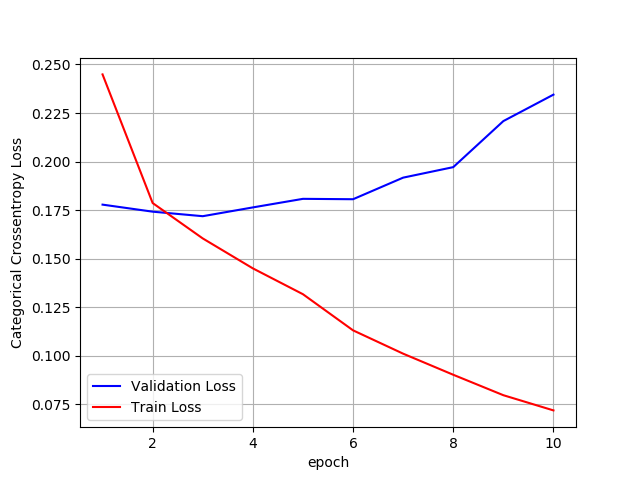

In [37]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')
x = list(range(1,11))
vy = model.history.history['val_loss']
ty = model.history.history['loss']
plt_dynamic(x, vy, ty, ax)

### Model 2 

In [38]:
# create the model
embedding_vecor_length = 32
model2 = Sequential()
model2.add(Embedding(top_words+1, embedding_vecor_length, input_length=max_review_length))
model2.add(LSTM(100,return_sequences=True))
model2.add(Dropout(0.25))
model2.add(LSTM(80))
model2.add(Dropout(0.5))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model2.summary())

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 600, 32)           160032    
_________________________________________________________________
lstm_2 (LSTM)                (None, 600, 100)          53200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 600, 100)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 80)                57920     
_________________________________________________________________
dropout_2 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 81        
Total params: 271,233
Train

In [39]:
history2=  model2.fit(Xtrain, Ytrain,
          batch_size=64,
          epochs=10,
          verbose=1,
          validation_data=(Xtest, Ytest))# Final evaluation of the model
scores = model2.evaluate(Xtest, Ytest, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 70000 samples, validate on 30000 samples
Epoch 1/10
70000/70000 [==============================] - 3748s 54ms/step - loss: 0.2410 - acc: 0.9094 - val_loss: 0.1789 - val_acc: 0.9314
Epoch 2/10
70000/70000 [==============================] - 3726s 53ms/step - loss: 0.1820 - acc: 0.9304 - val_loss: 0.2170 - val_acc: 0.9139
Epoch 3/10
70000/70000 [==============================] - 4011s 57ms/step - loss: 0.1624 - acc: 0.9375 - val_loss: 0.1718 - val_acc: 0.9372
Epoch 4/10
70000/70000 [==============================] - 3585s 51ms/step - loss: 0.1424 - acc: 0.9465 - val_loss: 0.1733 - val_acc: 0.9343
Epoch 5/10
70000/70000 [==============================] - 3590s 51ms/step - loss: 0.1235 - acc: 0.9548 - val_loss: 0.1864 - val_acc: 0.9331
Epoch 6/10
70000/70000 [==============================] - 3581s 51ms/step - loss: 0.1078 - acc: 0.9613 - val_loss: 0.1763 - val_acc: 0.9363
Epoch 7/10
70000/70000 [==============================] - 3581s 51ms/step - loss: 0.0962 - acc: 0.9662 - val_l

In [40]:
score= model2.evaluate(Xtest, Ytest, verbose=0)
print('Test score: ',score[0])
print('Test accuracy: ',score[1])

Test score:  0.2245582093084852
Test accuracy:  0.9295


<IPython.core.display.Javascript object>


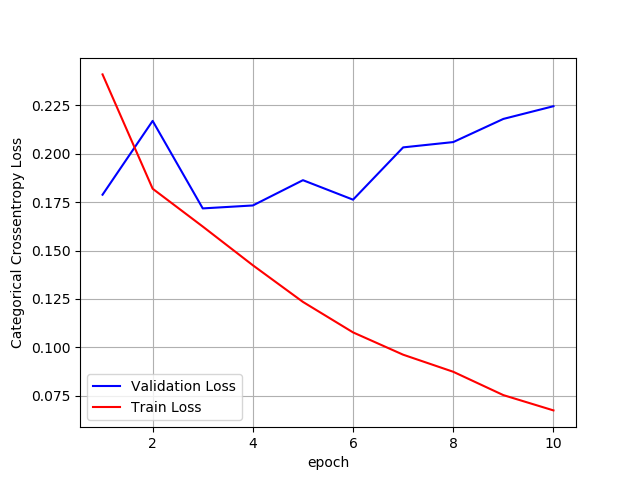

In [41]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')
x = list(range(1,11))
vy = model2.history.history['val_loss']
ty = model2.history.history['loss']
plt_dynamic(x, vy, ty, ax)

## Testing our model on self made review sentence

In [42]:
# making a function which convert sentance to requred vectorized format that will feed well in model

def cleanhtml(sentance): #substitute expression contained in <> with ' '
    cleaned= re.sub(re.compile('<.*?>'),' ',sentance)
    return cleaned
#function for removing punctuations chars
def cleanpunc(sentance):
    cleaned= re.sub(r'[?|!|\'|"|#]',r'',sentance)
    cleaned= re.sub(r'[.|,|)|(|\|/]',r'',sentance)
    return cleaned
snowstem= sno('english')

def predict_this(sentance):
    i=0
    str1=' '
    final_string=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    sent= sentance
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        # we have used cleanpunc(w).split(), one more split function here 
        # because consider w="abc.def", cleanpunc(w) will return "abc def"
        # if we dont use .split() function then we will be considring "abc def" 
        # as a single word, but if you use .split() function we will get "abc", "def"
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                s=(snowstem.stem(cleaned_words.lower())).encode('utf8')
                filtered_sentence.append(s)
                if(data['Score'].values)[i] =='Positive':
                    all_positive_words.append(s)
                if(data['Score'].values)[i] =='Negative':
                    all_negative_words.append(s)
            else:
                continue
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    final_string.append(str1)

    final_string
    for i in final_string:
        final_string=i.decode("utf-8")

    lis=[]
    for word in final_string.split():
        if word in sorted_list:
            lis.append(sorted_list.index(word)+1)

    final_string= lis
    final_string = sequence.pad_sequences([final_string], maxlen=max_review_length)
    print(final_string)
    what= ''
    if (round(float(model2.predict(final_string)))==1):
        what= 'Positive'
        acc= round(float(model2.predict(final_string))*100,2)
    else:
        what='Negative'
        acc= 100- round(float(model2.predict(final_string))*100,2)
    print(what,'review with',acc,'% Accuracy')

In [43]:
sentance= 'food was very bad in taste'
predict_this(sentance)

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0 

In [44]:
sentance= 'taste of chocolate was fantastic'
predict_this(sentance)

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0 

In [45]:
sentance= 'food was medium tasty'
predict_this(sentance)

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0 

In [46]:
print(data['Text'][1])
predict_this(data['Text'][1])

Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0 

# Summary 

* Accuracy of First model is 93.13%
* Accuracy of Second model is 92.95%